In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers, models
import shap
from PIL import Image
import time
import matplotlib.pyplot as plt

/opt/anaconda3/envs/aki/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator()

train_gen = datagen.flow_from_directory(
    '../data/teeth_cropped/train/',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    '../data/teeth_cropped/val/',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    '../data/teeth_cropped/test/',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 65 images belonging to 2 classes.
Found 17 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [3]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_gen, validation_data=val_gen, epochs=6)

2025-05-15 22:26:08.580525: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-05-15 22:26:08.580550: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-15 22:26:08.580553: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-15 22:26:08.580568: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-15 22:26:08.580578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/6


/opt/anaconda3/envs/aki/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-15 22:26:11.196596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 915ms/step - accuracy: 0.4465 - loss: 1.1505 - val_accuracy: 0.7059 - val_loss: 0.5227
Epoch 2/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8690 - loss: 0.3430 - val_accuracy: 0.9412 - val_loss: 0.2180
Epoch 3/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9228 - loss: 0.2211 - val_accuracy: 1.0000 - val_loss: 0.0614
Epoch 4/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9915 - loss: 0.0650 - val_accuracy: 1.0000 - val_loss: 0.0427
Epoch 5/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9708 - loss: 0.0601 - val_accuracy: 1.0000 - val_loss: 0.0458
Epoch 6/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9923 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.0378


PartitionExplainer explainer: 2it [00:17, 17.99s/it]               


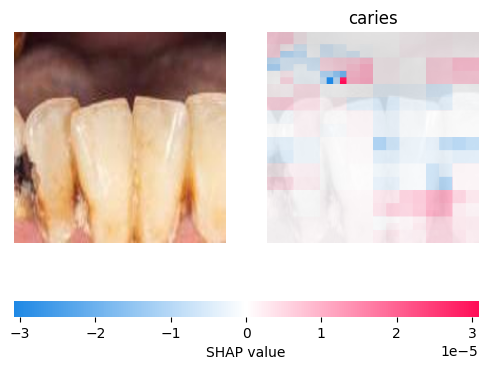

In [4]:
img_path = "../data/teeth_cropped/test/caries/90.jpg"
img = Image.open(img_path).convert('RGB').resize((224, 224))
img_np = np.array(img)
img_batch = np.expand_dims(img_np, axis=0)
img_preprocessed = preprocess_input(img_batch.copy())

X = img_preprocessed

def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=["caries", "healthy"])

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
#X_orig = X[[1]]  # Use original RGB values, not preprocessed
#X_display = X_orig / 255.0  # if original image is in [0, 255]
shap_values = explainer(X, max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values, img_batch, show=False)
plt.savefig("../outputs/shap_caries.png")